In [85]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from itertools import chain

def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]

def tmp_generator(gamma_dict,num,q_dict,q_num,L):
    bin=gamma_dict[0].shape[0]
    if q_num<=0:
        q=np.matrix(np.ones((bin,bin)))
    else:
        q=q_dict[q_num]
    tmp_gamma=np.zeros((bin,bin))
    tmp_q=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            if gamma_dict[num-L].item(i,j) != 0:
                tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
                tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
            else:
                tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/(1.0e-9)
                tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/(1.0e-9)
    return np.matrix(tmp_gamma),np.matrix(tmp_q)     

def assess(bin,f,g,C,V,output):
    output=output.A1.reshape((bin,bin))
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f)))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g)))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('tr violation:',sum(abs(output.T@V)))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'supp($X$)',fontsize=10)
    ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

def v_value(x0,x1,x):
    if x != 0:
        return (x0-x1)/x
    else:
        return 0
    
def newton(fun,dfun,a, stepmax, tol):
    if abs(fun(a))<=tol: return a
    for step in range(1, stepmax+1):
        b=a-fun(a)/dfun(a)
        if abs(fun(b))<=tol:
            return b
        else:
            a = b
    return b 

# simplist
def baseline(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    #I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_classic=dict()
    gamma_classic[0]=np.matrix(xi+1.0e-9)
    for repeat in range(K):
        gamma_classic[1+2*repeat]=np.matrix(np.diag((px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
        gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_classic[2*K])
    return gamma_classic

# our method | total repair
def total_repair(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    J=np.where(~((gamma_dict[2].T @ V).A1 ==0))[0].tolist()
    nu=np.zeros(bin)
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in J:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        dfun = lambda z: sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        J=np.where(~((abs(np.matrix(tmp).T @ V).A1)<=1.0e-5))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in J:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
            dfun = lambda z: sum(tmp.item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[K*L])
    return gamma_dict

# our method | partial repair
def partial_repair(C,e,px,ptx,V,theta_scale,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    theta=bbm1*theta_scale
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    Jplus=np.where(~((gamma_dict[2].T @ V).A1 <=theta.A1))[0].tolist()
    Jminus=np.where(~((gamma_dict[2].T @ V).A1>=-theta.A1))[0].tolist()
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in Jplus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    for j in Jminus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        Jplus=np.where(~((np.matrix(tmp).T @ V).A1 <=theta.A1))[0].tolist()
        Jminus=np.where(~((np.matrix(tmp).T @ V).A1>=-theta.A1))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in Jplus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        for j in Jminus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*K])
    return gamma_dict

def empirical_distribution(sub,x_range):
    bin=len(x_range)
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==x_range[i]] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def plot_rdist(rdist,x_range):
    plt.plot(x_range,rdist['x'],label=r'$Pr[x]$',color='tab:blue')
    plt.plot(x_range,rdist['x_0'],label=r'$Pr[x|s_0]$',alpha=0.3,color='tab:orange')
    plt.plot(x_range,rdist['x_1'],label=r'$Pr[x|s_1]$',alpha=0.3,color='#9f86c0')
    plt.ylabel('PMF',fontsize=14)
    plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=20)
    plt.legend()
    return plt

def DisparateImpact(X_test,y_pred):
    dim=X_test.shape[1]-2
    df_test=pd.DataFrame(np.concatenate((X_test,y_pred.reshape(-1,1)), axis=1),columns=[*range(dim)]+['S','W','f'])
    numerator=sum(df_test[(df_test['S']==0)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==0]['W'])
    denominator=sum(df_test[(df_test['S']==1)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==1]['W'])
    return numerator/denominator
    
def rdata_analysis(rdata,x_range,x_name):
    rdist=dict()
    pivot=pd.pivot_table(rdata,index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot0=pd.pivot_table(rdata[rdata['S']==0],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot1=pd.pivot_table(rdata[rdata['S']==1],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    rdist['x']= np.array([pivot[i] for i in x_range])/sum([pivot[i] for i in x_range]) #empirical_distribution(rdata,x_range)
    rdist['x_0']=np.array([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range])/sum([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==0],x_range)
    rdist['x_1']=np.array([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range])/sum([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==1],x_range)
    return rdist

def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j]) 
    return C

def c_generate_higher(x_range,weight):
    bin=len(x_range)
    dim=len(x_range[0])
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=sum(weight[d]*abs(x_range[i][d]-x_range[j][d]) for d in range(dim))
    return C

def projection(df,coupling_matrix,x_range,x_name,var_list):
    bin=len(x_range)
    var_list_tmp=var_list[:]
    var_list_tmp.remove(x_name)
    var_list_tmp=[x_name]+var_list_tmp # place the var that needs to be repaired the first
    df=df[var_list_tmp+['S','W','Y']]
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=var_list_tmp+['S','W','Y'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=np.where([x_range[i]==orig[x_name] for i in range(bin)])[0][0]
        rows=np.nonzero(coupling[loc,:])[0]
        sub_dict={x_name:[x_range[r] for r in rows],'W':list(coupling[loc,rows]/(sum(coupling[loc,rows]))*orig['W'])}
        sub_dict.update({var:[orig[var]]*len(rows) for var in var_list_tmp[1:]+['S','Y']})
        sub=pd.DataFrame(data=sub_dict, index=rows)
        df_t=pd.concat([df_t,sub],ignore_index=True)#pd.concat([df_t,samples_groupby(sub,x_list)], ignore_index=True)
    df_t=df_t.groupby(by=list(chain(*[var_list,'S','Y'])),as_index=False).sum()
    df_t=df_t[var_list+['S','W','Y']]
    return df_t

def projection_higher_wlabel(df,coupling_matrix,x_range,x_list,var_list):
    dim=len(x_list)
    #df=df.drop(columns=x_list)
    bin=len(x_range)
    arg_list=[elem for elem in var_list if elem not in x_list]
    df=df[arg_list+['X','S','W']]
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=arg_list+['X','S','W'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=np.where([x_range[i]==orig['X'] for i in range(bin)])[0][0]
        rows=np.nonzero(coupling[loc,:])[0]
        sub_dict={'X':[x_range[r] for r in rows],'W':list(coupling[loc,rows]/(sum(coupling[loc,rows]))*orig['W'])}
        sub_dict.update({var:[orig[var]]*len(rows) for var in arg_list+['S']})
        sub=pd.DataFrame(data=sub_dict, index=rows)
        df_t=pd.concat([df_t,sub],ignore_index=True)#pd.concat([df_t,samples_groupby(sub,x_list)], ignore_index=True)
    df_t=df_t.groupby(by=list(chain(*[arg_list,'X','S'])),as_index=False).sum()
    for d in range(dim):
        df_t[x_list[d]]=[df_t['X'][r][d] for r in range(df_t.shape[0])]
    return df_t[var_list+['S','W']]

In [155]:
e=0.01
K=150
var_list=['age','capitalgain','capitalloss','education-num','hoursperweek','class'] # 'class' must in the end #'age','capitalgain','capitalloss',
var_dim=len(var_list)
messydata=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv',usecols=var_list+['race'])
#S=1: White S=0: Black
messydata=messydata[(messydata['race']=='White')|(messydata['race']=='Black')]
messydata['race']=messydata['race'].replace('White',1)
messydata['race']=messydata['race'].replace('Black',0)
messydata['class']=messydata['class'].replace('>50K',1)
messydata['class']=messydata['class'].replace('<=50K',0)
for col in ['race','class']+var_list:
    messydata[col]=messydata[col].astype('category')
#cat_columns = messydata.select_dtypes(['category']).columns
#messydata[cat_columns]=messydata[cat_columns].apply(lambda x: x.cat.codes)
messydata=messydata.rename(columns={'race':'S'}) #'education-num':'X1','hoursperweek':'X2',
messydata['W']=1

tv_dist=dict()
for x_name in var_list:
    x_range=list(pd.pivot_table(messydata,index=x_name,values=['W'])[('W')].index) 
    dist=rdata_analysis(messydata,x_range,x_name)
    tv_dist[x_name]=sum(abs(dist['x_0']-dist['x_1']))

In [156]:
tv_dist

{'age': 0.08298460294670768,
 'capitalgain': 0.053529107898460285,
 'capitalloss': 0.028435566957486356,
 'education-num': 0.23735926565013912,
 'hoursperweek': 0.2443234639017859,
 'class': 0.2663515575402966}

In [157]:
weight=[1,4,4,16] # because education-num's range is 4 times of that of hoursperweek
x_list=['education-num','age','hoursperweek','class'] #score(X, y, sample_weight=None) #
dim=len(x_list)
X=messydata[list(chain(*[var_list[:-1],'S','W']))].to_numpy()
y=messydata['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=var_list[:-1]+['S','W','class'])
df=df.groupby(by=var_list+['S'],as_index=False).sum()
df=df[var_list+['S','W']]

x_range=list(pd.pivot_table(df,index=list(chain(*[x_list])),values=['W']).index)
df['X']=[tuple(df[x_list].values[r]) for r in range(df.shape[0])]
dist=rdata_analysis(df,x_range,'X')
bin=len(x_range)
C=c_generate_higher(x_range,weight)
dist['t_x']=dist['x']#dist['x_0']*0.5+dist['x_1']*0.5 #
dist['v']=[v_value(dist['x_0'][i],dist['x_1'][i],dist['x'][i]) for i in range(bin)]
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T

rdata_base=projection_higher_wlabel(df,baseline(C,e,px,ptx,V,K)[K*2],x_range,x_list,var_list)
rdata_part2=projection_higher_wlabel(df,partial_repair(C,e,px,ptx,V,1.0e-2,K)[K*3],x_range,x_list,var_list)
X_train_orig=df[var_list[:-1]+['S','W']].to_numpy()
y_train_orig=df['class'].to_numpy().astype('int8')
clf=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_orig[:,0:var_dim-1],y_train_orig,sample_weight=X_train_orig[:,var_dim])
print(clf.score(X_train_orig[:,0:var_dim-1],y_train_orig,sample_weight=X_train_orig[:,var_dim]))
y_pred_orig=clf.predict(X_test[:,0:var_dim-1])
new_row = pd.Series({'DI':DisparateImpact(X_test,y_pred_orig),
                    'f1 macro':f1_score(y_test, y_pred_orig, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_orig, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_orig, average='weighted'),
                    'method':'origin'})
print(new_row)
X_train_base=rdata_base[var_list[:-1]+['S','W']].to_numpy()
y_train_base=rdata_base['class'].to_numpy().astype('int8')
clf_base=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_base[:,0:var_dim-1],y_train_base,sample_weight=X_train_base[:,var_dim])
print(clf_base.score(X_train_base[:,0:var_dim-1],y_train_base,sample_weight=X_train_base[:,var_dim]))
y_pred_base=clf_base.predict(X_test[:,0:var_dim-1])
new_row_base = pd.Series({'DI':DisparateImpact(X_test,y_pred_base),
                'f1 macro':f1_score(y_test, y_pred_base, average='macro'),
                'f1 micro':f1_score(y_test, y_pred_base, average='micro'),
                'f1 weighted':f1_score(y_test, y_pred_base, average='weighted'),
                'method':'baseline'})
print(new_row_base)
X_train_part=rdata_part2[var_list[:-1]+['S','W']].to_numpy()
y_train_part=rdata_part2['class'].to_numpy().astype('int8')
clf_part=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_part[:,0:var_dim-1],y_train_part,sample_weight=X_train_part[:,var_dim])
print(clf_part.score(X_train_part[:,0:var_dim-1],y_train_part,sample_weight=X_train_part[:,var_dim]))
y_pred_part=clf_part.predict(X_test[:,0:var_dim-1])
new_row_part = pd.Series({'DI':DisparateImpact(X_test,y_pred_part),
                'f1 macro':f1_score(y_test, y_pred_part, average='macro'),
                'f1 micro':f1_score(y_test, y_pred_part, average='micro'),
                'f1 weighted':f1_score(y_test, y_pred_part, average='weighted'),
                'method':'partial repair'})
print(new_row_part)

sum of violation of f: 7.576579198996717e-07
sum of violation of g: 1.4761548103661704e-15
total cost: 1.389013000336426e-05
entropy: 4.801336768411949
tr violation: [[0.53556356]]
sum of violation of f: 0.0028359572059548574
sum of violation of g: 0.00016215110405212545
total cost: 1.528017081299541
entropy: 4.966407206871851
tr violation: [[0.42431572]]
0.8168508683795034
DI             0.484599
f1 macro       0.700133
f1 micro       0.822865
f1 weighted    0.800282
method           origin
dtype: object
0.8148412565517067
DI             0.458108
f1 macro       0.673794
f1 micro       0.819689
f1 weighted     0.78768
method         baseline
dtype: object
0.8122314816708845
DI                   0.473176
f1 macro             0.681586
f1 micro             0.820442
f1 weighted          0.791356
method         partial repair
dtype: object


In [148]:
weight=[1,4,16] # because education-num's range is 4 times of that of hoursperweek
x_list=['education-num','hoursperweek','class'] #score(X, y, sample_weight=None)
dim=len(x_list)
X=messydata[list(chain(*[var_list[:-1],'S','W']))].to_numpy()
y=messydata['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=var_list[:-1]+['S','W','class'])
df=df.groupby(by=var_list+['S'],as_index=False).sum()
df=df[var_list+['S','W']]

x_range=list(pd.pivot_table(df,index=list(chain(*[x_list])),values=['W']).index)
df['X']=[tuple(df[x_list].values[r]) for r in range(df.shape[0])]
dist=rdata_analysis(df,x_range,'X')
bin=len(x_range)
C=c_generate_higher(x_range,weight)
dist['t_x']=dist['x']#dist['x_0']*0.9+dist['x_1']*0.1
dist['v']=[v_value(dist['x_0'][i],dist['x_1'][i],dist['x'][i]) for i in range(bin)]
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T

rdata_base=projection_higher(df,baseline(C,e,px,ptx,V,K)[K*2],x_range,x_list,var_list)
rdata_part2=projection_higher(df,partial_repair(C,e,px,ptx,V,1.0e-2,K)[K*3],x_range,x_list,var_list)
X_train_orig=df[var_list[:-1]+['S','W']].to_numpy()
y_train_orig=df['class'].to_numpy().astype('int8')
clf=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_orig[:,0:var_dim-1],y_train_orig,sample_weight=X_train_orig[:,var_dim])
print(clf.score(X_train_orig[:,0:var_dim-1],y_train_orig,sample_weight=X_train_orig[:,var_dim]))
y_pred_orig=clf.predict(X_test[:,0:var_dim-1])
new_row = pd.Series({'DI':DisparateImpact(X_test,y_pred_orig),
                    'f1 macro':f1_score(y_test, y_pred_orig, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_orig, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_orig, average='weighted'),
                    'method':'origin'})
print(new_row)
X_train_base=rdata_base[var_list[:-1]+['S','W']].to_numpy()
y_train_base=rdata_base['class'].to_numpy().astype('int8')
clf_base=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_base[:,0:var_dim-1],y_train_base,sample_weight=X_train_base[:,var_dim])
print(clf_base.score(X_train_base[:,0:var_dim-1],y_train_base,sample_weight=X_train_base[:,var_dim]))
y_pred_base=clf_base.predict(X_test[:,0:var_dim-1])
new_row_base = pd.Series({'DI':DisparateImpact(X_test,y_pred_base),
                'f1 macro':f1_score(y_test, y_pred_base, average='macro'),
                'f1 micro':f1_score(y_test, y_pred_base, average='micro'),
                'f1 weighted':f1_score(y_test, y_pred_base, average='weighted'),
                'method':'baseline'})
print(new_row_base)
X_train_part=rdata_part2[var_list[:-1]+['S','W']].to_numpy()
y_train_part=rdata_part2['class'].to_numpy().astype('int8')
clf_part=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_part[:,0:var_dim-1],y_train_part,sample_weight=X_train_part[:,var_dim])
print(clf_part.score(X_train_part[:,0:var_dim-1],y_train_part,sample_weight=X_train_part[:,var_dim]))
y_pred_part=clf_part.predict(X_test[:,0:var_dim-1])
new_row_part = pd.Series({'DI':DisparateImpact(X_test,y_pred_part),
                'f1 macro':f1_score(y_test, y_pred_part, average='macro'),
                'f1 micro':f1_score(y_test, y_pred_part, average='micro'),
                'f1 weighted':f1_score(y_test, y_pred_part, average='weighted'),
                'method':'partial repair'})
print(new_row_part)

sum of violation of f: 1.8450203183154913e-07
sum of violation of g: 3.4783916198766196e-16
total cost: 2.5713177315091836e-06
entropy: 3.5827434488323586
tr violation: [[0.42956477]]
sum of violation of f: 0.002521602899869255
sum of violation of g: 0.0002473747054156005
total cost: 3.1811241501982077
entropy: 4.045163810295449
tr violation: [[0.26357557]]
0.8208698148413951
DI              0.50176
f1 macro       0.684464
f1 micro       0.815221
f1 weighted    0.788753
method           origin
dtype: object
0.8201879875245687
DI              0.53264
f1 macro       0.687849
f1 micro       0.815221
f1 weighted    0.790226
method         baseline
dtype: object
0.8069261731629949
DI                   0.500614
f1 macro              0.67527
f1 micro             0.807686
f1 weighted          0.781736
method         partial repair
dtype: object


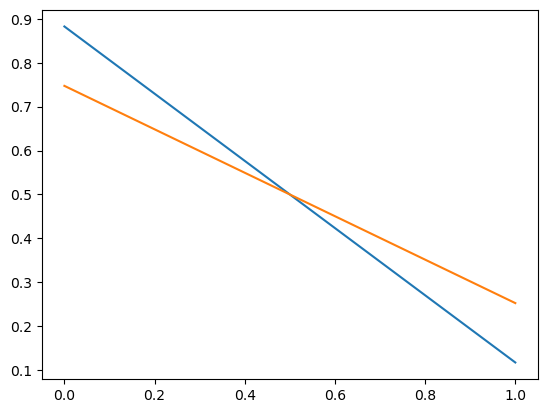

In [127]:
tmp=rdata_analysis(df,[*range(2)],'class')
plt.plot(tmp['x_0'])
plt.plot(tmp['x_1'])

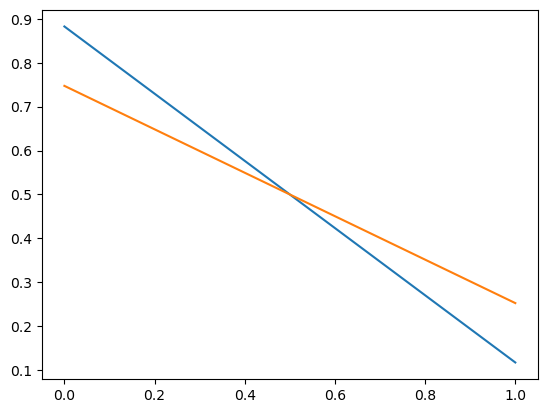

In [129]:
tmp=rdata_analysis(rdata_base,[*range(2)],'class')
plt.plot(tmp['x_0'])
plt.plot(tmp['x_1'])

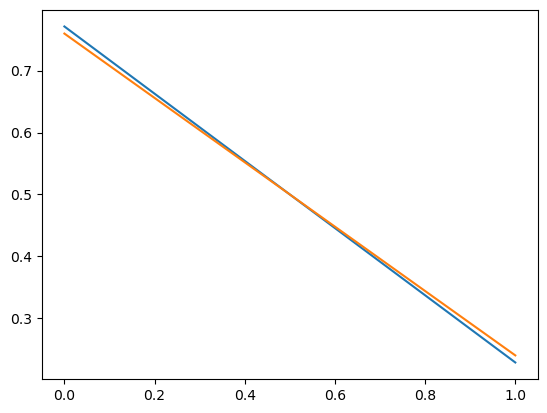

In [ ]:
tmp=rdata_analysis(rdata_part2,[*range(2)],'class')
plt.plot(tmp['x_0'])
plt.plot(tmp['x_1'])

In [111]:
clf=LogisticRegression(random_state=0).fit(X_train[:,0:var_dim-1],y_train,sample_weight=X_train[:,var_dim])
y_pred_orig=clf.predict(X_test[:,0:var_dim-1])
new_row = pd.Series({'DI':DisparateImpact(X_test,y_pred_orig),
                    'f1 macro':f1_score(y_test, y_pred_orig, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_orig, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_orig, average='weighted'),
                    'method':'origin'})
print(new_row)

DI               0.3347
f1 macro       0.616163
f1 micro       0.785026
f1 weighted    0.747288
method           origin
dtype: object
